  District    Sector  Latitude  Longitude Soil_Texture
0     Huye  Gishamvu   -2.6284    29.7453    ferralsol
1     Huye    Karama   -2.5942    29.7897    ferralsol
2     Huye    Maraba   -2.5523    29.7442    ferralsol
3     Huye    Mukura   -2.5831    29.6789      acrisol
4     Huye     Ngoma   -2.6173    29.7564    ferralsol
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   District      415 non-null    object 
 1   Sector        415 non-null    object 
 2   Latitude      415 non-null    float64
 3   Longitude     415 non-null    float64
 4   Soil_Texture  415 non-null    object 
dtypes: float64(2), object(3)
memory usage: 16.3+ KB
None
         Latitude   Longitude
count  415.000000  415.000000
mean    -2.010650   29.879868
std      0.364561    0.414186
min     -2.778900   29.023100
25%     -2.268900   29.583600
50%     -1.967800   29.8500

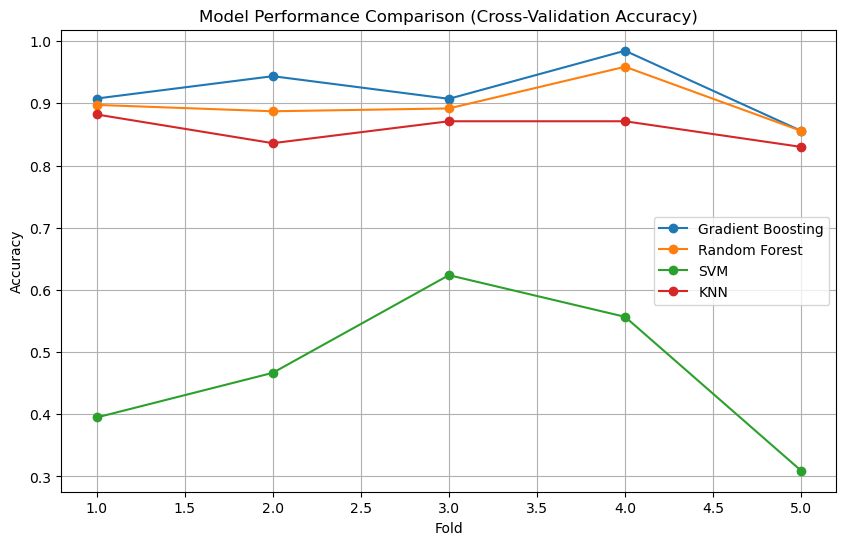


Best model for Soil Texture saved as 'Gradient Boosting_soil_texture_model.joblib'.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from joblib import dump

# Load dataset
dataset = pd.read_csv('./data/rwanda_soilTypes.csv')

print(dataset.head())
print(dataset.info())
print(dataset.describe())
print(dataset.isnull().sum())

# Display initial class distribution for 'Sector'
print("Initial Sector class distribution:")
print(dataset['Sector'].value_counts())

# Define the minimum number of samples for a sector to be retained (lower threshold)
min_samples = 1  # Lower threshold for filtering

# Count the number of samples in each sector
sector_class_counts = dataset['Sector'].value_counts()

# Check which sectors have fewer than min_samples
rare_classes = sector_class_counts[sector_class_counts < min_samples].index
print(f"\nRemoving sectors with fewer than {min_samples} samples: {rare_classes}")

# Filter out the rare classes
filtered_dataset = dataset[~dataset['Sector'].isin(rare_classes)]

# Check how many rows are left after filtering
print(f"\nRemaining dataset after filtering rare classes: {filtered_dataset.shape[0]} rows")

# Check class distribution again after filtering
print("\nClass distribution after filtering rare classes:")
print(filtered_dataset['Sector'].value_counts())

# Update features and targets for soil texture prediction
X_filtered = filtered_dataset[['District', 'Latitude', 'Longitude']]
y_soil_filtered = filtered_dataset['Soil_Texture']

# One-hot encode the district column
preprocessor = ColumnTransformer(
    transformers=[
        ('district', OneHotEncoder(), ['District'])
    ],
    remainder='passthrough'  # Keep Latitude and Longitude as they are
)

#  Save the preprocessor
preprocessor_path = './models/soil_preprocessor.joblib'
dump(preprocessor, preprocessor_path)

print(f"Preprocessor saved as '{preprocessor_path}'.")

# Resample the training data for imbalanced classes using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(preprocessor.fit_transform(X_filtered), y_soil_filtered)

# Models to evaluate
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Dictionary to store cross-validation scores
cv_scores_dict = {}

# Evaluate each model with cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_res, y_res, cv=5, scoring='accuracy')
    cv_scores_dict[model_name] = cv_scores
    print(f"\nEvaluating model: {model_name}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Average cross-validation accuracy: {cv_scores.mean():.4f}")

# Plotting the model performances
plt.figure(figsize=(10, 6))
for model_name, cv_scores in cv_scores_dict.items():
    plt.plot([i+1 for i in range(len(cv_scores))], cv_scores, label=model_name, marker='o')
    
plt.title('Model Performance Comparison (Cross-Validation Accuracy)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Best model selection based on cross-validation accuracy
best_model_name = max(cv_scores_dict, key=lambda x: cv_scores_dict[x].mean())
best_model = models[best_model_name]

# Train the best model on the entire resampled dataset
best_model.fit(X_res, y_res)

# Save the best model if it performs well
if cv_scores_dict[best_model_name].mean() > 0.1:  # Threshold for acceptable model performance
    dump(best_model, 'models/best_soil_texture_model.joblib')
    print(f"\nBest model for Soil Texture saved as '{best_model_name}_soil_texture_model.joblib'.")
else:
    print("\nNo model performed well enough for saving.")


In [9]:
import pandas as pd
from joblib import load
import os

def predict_soil_texture(district, sector):

    try:
        # Load the model and preprocessor
        model_path = 'models/best_soil_texture_model.joblib'
        preprocessor_path = 'models/soil_preprocessor.joblib'
        
        if not os.path.exists(model_path) or not os.path.exists(preprocessor_path):
            return "Error: Model or preprocessor file not found."
        
        model = load(model_path)
        preprocessor = load(preprocessor_path)
        
        # Load the original dataset to get coordinates
        try:
            dataset = pd.read_csv('./data/rwanda_soilTypes.csv')
            
            # Find average coordinates for the specific sector
            sector_data = dataset[(dataset['District'] == district) & (dataset['Sector'] == sector)]
            
            if len(sector_data) > 0:
                # Use average coordinates for the sector
                latitude = sector_data['Latitude'].mean()
                longitude = sector_data['Longitude'].mean()
            else:
                return f"Error: The combination of District '{district}' and Sector '{sector}' was not found in the dataset."
                
        except FileNotFoundError:
            return "Error: Dataset file not found."
        
        # Create a dataframe with the input data
        input_data = pd.DataFrame({
            'District': [district],
            'Latitude': [latitude],
            'Longitude': [longitude]
        })

        # Get a sample of the training data to fit the preprocessor
        training_data = dataset[['District', 'Latitude', 'Longitude']]
        
        # Fit the preprocessor on the training data
        preprocessor.fit(training_data)
        
        # Now transform the input data
        X_processed = preprocessor.transform(input_data)
        
        # Make the prediction
        prediction = model.predict(X_processed)[0]
        
        return prediction
    
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Example usage:
if __name__ == "__main__":
    # Example: Using only district and sector names
    district_name = input("Enter district name: ")
    sector_name = input("Enter sector name: ")
    
    soil_prediction = predict_soil_texture(district_name, sector_name)
    if isinstance(soil_prediction, str):
        print(f"Predicted soil texture for {district_name}, {sector_name}: {soil_prediction}")
    else:
        # If the prediction is successful, it will be a string with the predicted soil texture
        print(f"Predicted soil texture for {district_name}, {sector_name}: {soil_prediction}")


Predicted soil texture for Kayonza, Ndego: ferralsol
